In [1]:
# Install required packages in the current Jupyter kernel
# Uncomment the following lines if you need to install these libraries
# If you run into permission issues, try with the --user option
#import sys
#!pip install -q rdflib networkx matplotlib
#!{sys.executable} -m pip install rdflib networkx matplotlib pandas stringdb --user


In [3]:
%load_ext autoreload
%autoreload 2
import sampler
import grabhogs_sparql
import map2string_fast
import addfrombloom
import rdflib
import SPARQLWrapper
import colour
import itertools
import networkx as nx
import glob
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
datapath = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/402676.protein.links.rdf.v11.5.txt.gz'
# RDF graph loading
rg = sampler.load_graph(datapath)

datapath2 = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.info.rdf.v11.5/402676.protein.info.rdf.v11.5.txt.gz'
# RDF graph loading
rg_info  = sampler.load_graph(datapath2)

In [ ]:
links = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/*.protein.links.rdf.v11.5.txt.gz'
linkfiles = glob.glob(links)
linkfiles = { l:{ 'links':l , 'info':l.replace('protein.links' , 'protein.info' ) } for l in linkfiles}
print(len(linkfiles ))

In [ ]:
subjs = rg.subjects( unique = True)
seed = next(subjs)
print(seed)

In [ ]:
subg = sampler.sample( rg = rg , seed = seed,  layer_limit= 2 , sample_run = 20 )
print(set([p for p in subg.predicates()]))
print("rdflib Graph sampled successfully with {} triples".format(len(subg)))



In [ ]:
subg = sampler.add_xrefs( rg_info , subg )
print("rdflib Graph annotated successfully with {} triples".format(len(subg)))
print(set([p for p in subg.predicates()]))
cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot")
i = 0 
for s,p,o in subg.triples((None, cross_ref, None)):
    print(s,p,o)
    i+= 1
    if i > 10:
        break

In [ ]:
#proteins_by_species , results_subj_para , results_subj_ortho  = grabhogs_sparql.grab_hogs( subg , cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot") )

In [ ]:
#print(results_subj_ortho)

In [ ]:
orthograph =  grabhogs_sparql.grab_hogs_graph( subg , cross_ref , sparql_endpoint= None
            , USE_CASE = 1 , verbose = True , cross_ref_prop = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot"))

In [40]:
from rdflib import Graph, URIRef
print("rdflib Graph annotated successfully with {} triples".format(len(orthograph)))
#get all species
taxa = [ 'protein1_uniprot_taxon_orth' , 'protein1_uniprot_taxon_para']
species = set( [ o for t in taxa  for s,p,o in orthograph.triples((None, URIRef(t), None))  ])


rdflib Graph annotated successfully with 446218 triples


In [41]:
#get all the results for that species
taxa = [ 'orth_protein_uniprot_taxon_orth' , 'para_protein_uniprot_taxon_para']
#get all proteins for each species
prots_by_species = { spec: set([s  for s,p,o in orthograph.triples((None, URIRef(t), spec ))]) for t in taxa for spec in species  }
prots_by_species = { spec:prots_by_species[spec] for spec in prots_by_species if len(prots_by_species[spec])   }
prots_by_species = { spec:[ p.replace('http://purl.uniprot.org/uniprot/' , '' ) for p in prots_by_species[spec] ] for spec in prots_by_species }


In [42]:
server = 'dna067'
ortho_xrefgraph = map2string_fast.mapall(prots_by_species , serverurl= "http://"+server+":3030/string_fuseki/sparql" , retgraph = True)
print(len(ortho_xrefgraph))

5848


In [43]:
orthograph += ortho_xrefgraph
subg += orthograph
#we have interactions for one species and ortho info to all others

In [ ]:
filters = addfrombloom.load_filters()

In [56]:
import addfrombloom
pred = rdflib.term.URIRef('http://purl.org/lscr#xrefUniprot')
interactions = []
for i,spec in enumerate(prots_by_species):
    stringids = [ s for prot in prots_by_species[spec] for s,p,o in orthograph.triples((None, pred , URIRef('http://purl.uniprot.org/uniprot/'+prot) )) ]
    stringids = [ s.replace('https://string-db.org/network/' , '' ) for s in stringids ]
    before = len(interactions)
    if len(stringids ) > 2 :
        interactions += addfrombloom.check_allvall( objects = stringids , urlstring = 'https://string-db.org/network/' , filters = filters )
        if len(interactions)-before>0:
            print('found {} interactions for species {}'.format(len(interactions)-before , spec))
            print(len(subg))
            for inter in interactions:
                subg = subg.add( inter)
            print(len(subg))
            interactions = []
    if i % 10 == 0 :
        print('saving')
        v = subg.serialize(format="ttl")
        with open('testgraph_'+str(i)+'.ttl', 'w') as graphout:
            graphout.write(v)

found 78 interactions for species http://purl.uniprot.org/taxonomy/29073
453818
453857
saving
found 76 interactions for species http://purl.uniprot.org/taxonomy/7227
453857
453895
found 116 interactions for species http://purl.uniprot.org/taxonomy/10116
453895
453953
found 78 interactions for species http://purl.uniprot.org/taxonomy/7217
453953
453992
found 60 interactions for species http://purl.uniprot.org/taxonomy/9739
453992
454022
found 24 interactions for species http://purl.uniprot.org/taxonomy/9545
454022
454034
found 216 interactions for species http://purl.uniprot.org/taxonomy/988480
454034
454142
found 86 interactions for species http://purl.uniprot.org/taxonomy/72359
454142
454185
saving
found 138 interactions for species http://purl.uniprot.org/taxonomy/284811
454185
454254
found 184 interactions for species http://purl.uniprot.org/taxonomy/48709
454254
454346
found 102 interactions for species http://purl.uniprot.org/taxonomy/161767
454346
454397
found 134 interactions fo

KeyboardInterrupt: 

In [ ]:
#halelujah we have a graph with everything in it
#serialize to turtle format
v = subg.serialize(format="ttl")
with open('testgraph.ttl', 'w') as graphout:
    graphout.write(v)

In [4]:
import rdflib
readg = rdflib.Graph()
readg.parse('./testgraph_20.ttl')
print(len(readg))
#we can save the subgraphs in rdf...

454722


In [22]:
# create a new heterodata object
from rdflib import URIRef
from torch_geometric.data import HeteroData , Data
import torch_geometric.transforms as T
import torch_geometric.utils 
from rdflib import RDF
import numpy as np
import itertools
import scipy.sparse
import torch

def sparse2pairs(sparsemat, matrows = None):
    '''
    This functino takes a sparse matrix and returns a list of pairs of the non zero entries
    args:
        sparsemat: a sparse matrix
        matrows: a list of the matrix rows to keep
    Returns:    
        a list of pairs of the non zero entries
    '''
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def test_heterograph(rdf_graph , verbose = True):
    data = HeteroData()
    # assign edge types from the predicate
    edge_types = set([p for s,p,o in rdf_graph])
    edge_types = {e:i for i,e in enumerate(edge_types)}
    uris = {}
    subtypes = {}
    for sub, pred, obj in rdf_graph:
        for o in (sub,obj):
            if isinstance(o, URIRef):
                uri_type = rdf_graph.qname(o).split(":")[0]  # get the namespace prefix
                if uri_type not in uris:
                    uris[uri_type] = []
                    subtypes[uri_type] = set([])
                uris[uri_type].append(o)
                subtypes[uri_type].add( ''.join(o.n3().split('/')[0:-1] )  )
    
    
    allsubtypes = {}
    inputdims = {}

    for t in subtypes:
        #compile the x data matrix for each subtype
        subtype_dict = { ty:i for i,ty in enumerate(subtypes[t])}
        allsubtypes[t] = subtype_dict
        indices = [ subtype_dict[''.join(o.n3().split('/')[0:-1])] for o in uris[t] ]
        x= np.zeros( (len(uris[t]), len(subtype_dict)))
        inputdims[t] = len(subtype_dict)
        x[:,indices] = 1
        #for now this is 1hot for subtype
        #add some more descriptive data here if you have it
        data[t].x = torch.tensor(x , dtype=torch.float )
    
    node_index_by_type = { uritype : { n:i for i,n in enumerate( set(uris[uritype]) ) } for uritype in uris }
    #todo add the diff types of uris within each namespace as 1hot encoded for x attribute of each node
    
    interactions = {}
    for t1,t2 in itertools.product(node_index_by_type,node_index_by_type):
            rows = node_index_by_type[t1]
            columns = node_index_by_type[t2]
            
            if verbose == True:
                print(t1,len(rows),t2, len(columns)) 
            for edge_type in edge_types:
                
                #add the number of input dimension for the rows here
                #for now this is just the subtype 1 hot. theres prob a more elegant way to pass this info along or get it from the data obj
                
                # create a dictionary of nodes
                triples =  [ (s,p,o) for s,p,o in rdf_graph.triples((None, edge_type, None))  if ( s in rows and o in columns )  ]
                if len(triples)>0:

                    interactions[(t1,edge_type.n3(),t2)] = len(allsubtypes[t1])
                    interactions[(t2, 'rev_'+edge_type.n3(),t1)] = len(allsubtypes[t1])


                    adj = scipy.sparse.lil_matrix((len(rows), len(columns)))
                    for s,p,o in triples:
                        adj[rows[s], columns[o]] = 1
                    if verbose == True:
                        print('nadj:', adj.sum())
                        print( t1,len(node_index_by_type[t1]) ,t2, len(node_index_by_type[t2]))
                        print( edge_type , len(triples) )
                    if adj.sum() >0 :
                        #between subgraphs
                        data[ t1 , edge_type.n3() , t2 ].edge_index = torch.tensor( sparse2pairs(adj) ,  dtype=torch.long )
                        if t1 == t2:
                            #within a subgraph of the same namespace
                            torch_geometric.utils.add_self_loops(data[ t1 , edge_type.n3() , t2 ].edge_index )
    
    data = T.ToUndirected()(data)
    data = T.AddSelfLoops()(data)
    return data , inputdims , interactions 
data , inputdims , interactions  = test_heterograph(readg)
print(data , inputdims , interactions )

ns4 36489 ns4 36489
nadj: 14413.0
ns4 36489 ns4 36489
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_para_protein 14413
nadj: 33804.0
ns4 36489 ns4 36489
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_orth_protein 33804
ns4 36489 ns3 1073
nadj: 55.0
ns4 36489 ns3 1073
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon 55
nadj: 9342.0
ns4 36489 ns3 1073
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/para_protein_taxon_para 9342
nadj: 20703.0
ns4 36489 ns3 1073
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_orth 20703
nadj: 5917.0
ns4 36489 ns3 1073
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_para 5917
nadj: 27910.0
ns4 36489 ns3 1073
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/orth_protein

In [62]:
#set the network prediction link type
pred_s,pred_p,pred_o = ('ns6', '<https://string-db.org/rdf/any-confidence>', 'ns6')
#final dim before the dot product


In [63]:
#get a model
import buildmodel
outputdims = { t : 50 for t in inputdims }
model = buildmodel.HeteroGCN_linkpred( linkpred = (pred_s,pred_p,pred_o) , inpudims= inputdims, interactions = interactions , outputdims= outputdims , layers = [100,100,100 , 100] , tan_final = True)
print(model)

{('ns4', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_para_protein>', 'ns4'): EdgeConv(), ('ns4', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_para_protein>', 'ns4'): EdgeConv(), ('ns4', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_orth_protein>', 'ns4'): EdgeConv(), ('ns4', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_orth_protein>', 'ns4'): EdgeConv(), ('ns4', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon>', 'ns3'): EdgeConv(), ('ns3', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon>', 'ns4'): EdgeConv(), ('ns4', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/para_protein_taxon_para>', 'ns3'): EdgeConv(), ('ns3', 'rev_<file:///work/FAC/FBM/DBC/cdessim2

In [64]:
#sample edges
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
#HERE the only EDGE TYPE you would use for split would be ("protein", "interacts", "protein")
# although the graph would also contain ("protein", "isOrtho", "protein")
# maybe also species as a link?? or should it be a node feature

if pred_s == pred_o:
    revpred = (pred_s,pred_p,pred_o)
else:
    revpred  = pred_o, 'rev_'+pred_p,pred_s

transform = T.RandomLinkSplit(
    num_val=0.1,  # percentage of VALIDATION
    num_test=0.1,  # percentage of TESTING
    disjoint_train_ratio=0.3,  # this somehow has to do with the 30% we need for supervision
    neg_sampling_ratio=2,  # TODO
    add_negative_train_samples=True,  # TODO
    edge_types=(pred_s,pred_p,pred_o),
    rev_edge_types=(pred_s,pred_p,pred_o), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  ns4={ x=[334965, 1] },
  ns3={ x=[217024, 1] },
  ns5={ x=[346295, 1] },
  ns6={ x=[11108, 1] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_para_protein>, ns4)={ edge_index=[2, 363777] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_orth_protein>, ns4)={ edge_index=[2, 402573] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon>, ns3)={ edge_index=[2, 55] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/para_protein_taxon_para>, ns3)={ edge_index=[2, 9342] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_orth>, ns3)={ edge_index=[2, 20703] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_para>, ns3)={ edge_index=[2, 5917] },
  (ns4, <f

In [65]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader
# Define seed edges:
## HERE IS where you would basically train with both types of links, but then for testing you would only want to generate INTERACT
edge_label_index = train_data[pred_s,pred_p,pred_o].edge_label_index
edge_label = train_data[pred_s,pred_p,pred_o].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,  # TODO
    num_neighbors=[20, 20 , 20],  # TODO
    edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
    #edge_label=edge_label,
    neg_sampling_ratio=2,  # TODO
    batch_size=1000,
    shuffle=True
)


# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  ns4={ x=[14757, 1] },
  ns3={ x=[638, 1] },
  ns5={ x=[15593, 1] },
  ns6={ x=[4717, 1] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_para_protein>, ns4)={ edge_index=[2, 7236] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_orth_protein>, ns4)={ edge_index=[2, 3646] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon>, ns3)={ edge_index=[2, 20] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/para_protein_taxon_para>, ns3)={ edge_index=[2, 6103] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_orth>, ns3)={ edge_index=[2, 7190] },
  (ns4, <file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/protein1_taxon_para>, ns3)={ edge_index=[2, 4577] },
  (ns4, <file://

In [66]:
#train
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(1, 100):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)
        pred = model.forward(sampled_data )
        loss = F.binary_cross_entropy_with_logits(pred , sampled_data[pred_s,pred_p,pred_o].edge_label)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel() # numel = number of elements
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")


Device: 'cuda'


  0%|          | 0/10 [00:00<?, ?it/s]/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/ML2/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Epoch: 001, Loss: 1.0127


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 002, Loss: 0.8011


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 003, Loss: 0.7399


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 004, Loss: 0.7168


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 005, Loss: 0.7028


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 006, Loss: 0.6964


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 007, Loss: 0.6872


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 008, Loss: 0.6816


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 009, Loss: 0.6768


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 010, Loss: 0.6774


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 011, Loss: 0.6729


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 012, Loss: 0.6690


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 013, Loss: 0.6679


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 014, Loss: 0.6657


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 015, Loss: 0.6649


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 016, Loss: 0.6624


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 017, Loss: 0.6621


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 018, Loss: 0.6621


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 019, Loss: 0.6605


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 020, Loss: 0.6615


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 021, Loss: 0.6595


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 022, Loss: 0.6589


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 023, Loss: 0.6585


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 024, Loss: 0.6594


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 025, Loss: 0.6568


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Epoch: 026, Loss: 0.6555


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 027, Loss: 0.6563


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 028, Loss: 0.6573


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 029, Loss: 0.6541


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 030, Loss: 0.6573


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 031, Loss: 0.6541


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 032, Loss: 0.6539


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch: 033, Loss: 0.6564


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 034, Loss: 0.6508


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 035, Loss: 0.6544


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 036, Loss: 0.6519


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 037, Loss: 0.6524


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 038, Loss: 0.6511


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 039, Loss: 0.6516


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 040, Loss: 0.6509


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 041, Loss: 0.6502


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 042, Loss: 0.6497


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 043, Loss: 0.6513


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 044, Loss: 0.6516


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 045, Loss: 0.6502


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 046, Loss: 0.6502


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 047, Loss: 0.6518


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 048, Loss: 0.6492


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 049, Loss: 0.6501


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 050, Loss: 0.6469


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 051, Loss: 0.6493


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 052, Loss: 0.6489


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 053, Loss: 0.6489


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 054, Loss: 0.6494


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 055, Loss: 0.6490


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 056, Loss: 0.6503


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 057, Loss: 0.6476


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 058, Loss: 0.6472


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 059, Loss: 0.6474


100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


Epoch: 060, Loss: 0.6474


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 061, Loss: 0.6481


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 062, Loss: 0.6474


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 063, Loss: 0.6479


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 064, Loss: 0.6471


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 065, Loss: 0.6456


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 066, Loss: 0.6458


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 067, Loss: 0.6469


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 068, Loss: 0.6477


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 069, Loss: 0.6475


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 070, Loss: 0.6461


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 071, Loss: 0.6463


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 072, Loss: 0.6447


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 073, Loss: 0.6461


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 074, Loss: 0.6461


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 075, Loss: 0.6446


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 076, Loss: 0.6451


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 077, Loss: 0.6455


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 078, Loss: 0.6452


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 079, Loss: 0.6446


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 080, Loss: 0.6440


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 081, Loss: 0.6447


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 082, Loss: 0.6459


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 083, Loss: 0.6438


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 084, Loss: 0.6455


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 085, Loss: 0.6446


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 086, Loss: 0.6441


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 087, Loss: 0.6457


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 088, Loss: 0.6449


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 089, Loss: 0.6444


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 090, Loss: 0.6435


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 091, Loss: 0.6453


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 092, Loss: 0.6426


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 093, Loss: 0.6431


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 094, Loss: 0.6442


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 095, Loss: 0.6449


100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


Epoch: 096, Loss: 0.6423


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 097, Loss: 0.6431


100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


Epoch: 098, Loss: 0.6436


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

Epoch: 099, Loss: 0.6429


In [71]:
#pred  and validate 

from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt


val_loader = LinkNeighborLoader(
    data=val_data,  # TODO
    num_neighbors=[20, 20 , 20],  # TODO
    edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
    #edge_label=edge_label,
    neg_sampling_ratio=2,  # TODO
    batch_size=1000,
    shuffle=True
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # TODO: Collect predictions and ground-truths and write them into
        # `preds` and `ground_truths`.
        sampled_data = sampled_data.to(device)
        pred = model.forward(sampled_data)
        preds += [pred]
        ground_truths += [sampled_data[pred_s,pred_p,pred_o].edge_label]

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

print()
print(f"Validation AUC: {auc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/ML2/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


Validation AUC: 0.6447


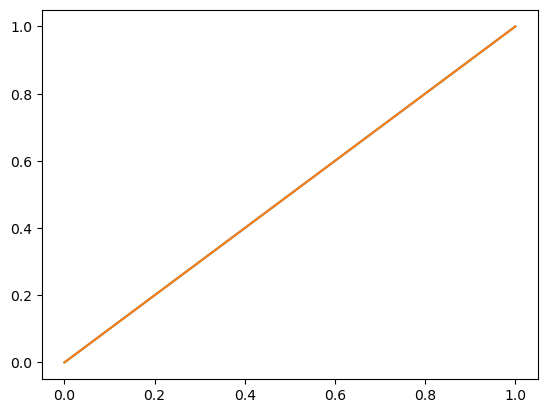

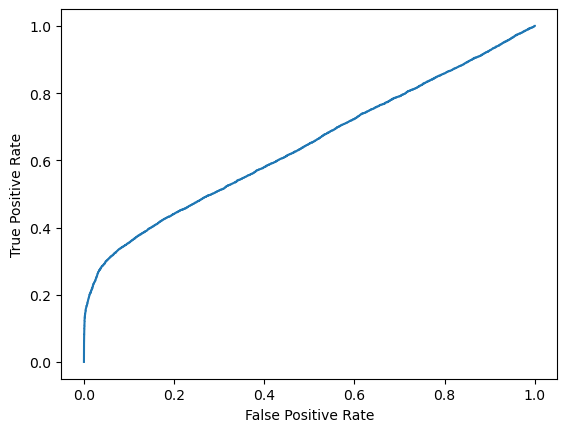

In [79]:

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


fpr, tpr, _ = roc_curve(ground_truth, pred)
plt.plot([[0,0],[1,1]] )
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

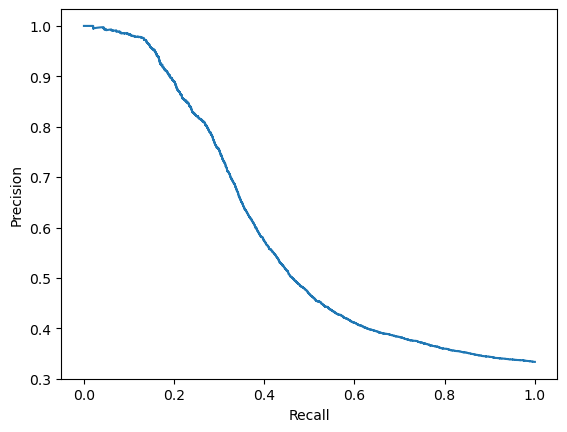

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(ground_truth, pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()